# Taller 4 · Codificación PCM: LPCM, DPCM y Delta Modulation

**Asignatura:** Teoría de la Información y Procesado de Señal  
**Grado en Ciencia e Ingeniería de Datos (GCED) — Universidad de A Coruña**  
**Duración:** 2 horas  
**Modalidad:** Jupyter Notebook con asistencia de IA (GitHub Copilot)

---

## Objetivos de aprendizaje

Al finalizar este taller serás capaz de:

1. Implementar una cadena **LPCM** (cuantificación directa de cada muestra).
2. Implementar **DPCM** con predicción simple y cuantificación del error de predicción.
3. Implementar **Delta Modulation (DM)** y entender sus requisitos de $F_s$.
4. Identificar **granular noise** y **slope overload** en DM.
5. Comparar MSE, SQNR y **régimen binario** entre los tres métodos.
6. Razonar sobre **cuándo cada método es más apropiado**.

---

## Entregables

- Notebook ejecutado completo (**Run All**) sin errores.
- Figuras correctamente etiquetadas (título, ejes, unidades).
- Secciones de **explicación** completadas con razonamiento propio.
- Respuestas a las preguntas de control.

---

## 🎯 Reto central del taller

> **A igualdad de calidad percibida (20~23 dB de SQNR), ¿qué esquema de codificación es más eficiente en términos de tasa binaria y por qué?**
>
> La codificación PCM (Pulse Code Modulation) convierte una señal cuantificada en una secuencia de bits. Pero no todos los esquemas PCM son iguales: algunos explotan la **redundancia temporal** de la señal para ser más eficientes. Este taller compara tres variantes para que lo compruebes experimentalmente.

---

## Metodología de trabajo con IA

En este curso **puedes y debes usar IA**, pero siguiendo estas reglas:

| Qué puede hacer la IA | Qué debes hacer tú |
|----------------------|--------------------|
| Generar código | Entenderlo y validarlo |
| Sugerir implementaciones | Diseñar el experimento |
| Completar sintaxis | Interpretar los resultados |

### Estructura obligatoria de cada bloque

1. **Implementación**: código generado (con o sin IA).
2. **Validación**: al menos un `assert` o comprobación numérica/visual.
3. **Explicación**: 2–5 líneas en tus propias palabras explicando *qué* ocurre y *por qué*.

> **Mensaje clave:** *La IA te ayuda a escribir código, pero no a entender señales. Eso es tu trabajo.*

---

## Identificación del estudiante

Completa los siguientes campos con tu información personal:

- **Apellidos:** López Bazarra

- **Nombre:** Juan

- **Email UDC:** juan.bazarra@udc.es

---

## 0. Setup inicial

Ejecuta esta celda para importar las librerías y reutilizar el cuantificador del Taller 3.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
plt.rcParams['figure.figsize'] = (10, 3)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 11

# Cuantificador uniforme del Taller 3 (lo reutilizamos)
def cuantificador_uniforme(x, B, xmin, xmax):
    """
    Cuantificador uniforme con REDONDEO (mid-rise).
    x_q, Delta = cuantificador_redondeo(x, B, xmin, xmax)
    
    x: valor de entrada
    B: número de bits
    xmin, xmax: rango de cuantificación
    x_q: valor cuantificado""" 

    rango = xmax - xmin
    L= 2 ** B
    Delta = rango / L

    l = np.floor((x - xmin) / Delta).astype(int)
    l = np.clip(l, 0, L - 1) # Asegura que l esté dentro del rango válido [0, L-1]
    
    x_q = l * Delta + xmin + Delta / 2

    return x_q, Delta

# Función para calcular MSE y SQNR
def calcular_metricas(x_orig, x_q):
    """Calcula MSE y SQNR entre señal original y reconstruida."""
    e = x_orig - x_q
    MSE = np.mean(e**2)
    P_x = np.mean(x_orig**2)
    SQNR_db = 10 * np.log10(P_x / MSE) if MSE > 0 else np.inf
    return MSE, SQNR_db

print("✓ Entorno listo (incluye funciones de cuantificador del Taller 3 y de cálculo de métricas).")

✓ Entorno listo (incluye funciones de cuantificador del Taller 3 y de cálculo de métricas).


---

## Contexto teórico: La familia PCM

La conversión analógico-digital (ADC) tiene tres etapas:

$$x_a(t) \xrightarrow{\text{Muestreo}} x(n) \xrightarrow{\text{Cuantificación}} x_q(n) \xrightarrow{\text{Codificación}} \text{bits}$$

En el Taller 3 estudiamos la cuantificación. Ahora nos centramos en **cómo codificar** las muestras cuantificadas en bits. La familia **PCM** (Pulse Code Modulation) agrupa varios métodos:

| Método | ¿Qué cuantifica? | Bits/muestra | Explota correlación |
|--------|-------------------|--------------|---------------------|
| **LPCM** | Cada muestra directamente | $B$ | No |
| **DPCM** | La diferencia $d[n] = x[n] - \hat{x}[n]$ | $B$ | Sí |
| **DM** | Solo el signo del error (subir/bajar) | 1 | Sí (extremo) |

**Idea clave:** Si la señal tiene **correlación temporal** (muestras consecutivas parecidas), el error de predicción tiene menor rango que la señal original. Cuantificar ese error con los mismos $B$ bits da **mejor calidad**.

**Régimen binario:** $R_b = B \cdot F_s$ bits/segundo. A menor $B$ (o menor $F_s$), menor ancho de banda necesario.

---

## Parte 1: Señales de partida

### Bloque 1 · Generación de señal compuesta

---

#### 📝 Hipótesis previa (COMPLETA ANTES de implementar/ejecutar)

**Preguntas:**

- Si las muestras consecutivas se parecen mucho (alta correlación), ¿qué método se beneficiaría? El metodo que cuantifica el error de predicción (DPCM o DM) se beneficiaría más, ya que el error sería pequeño y podría ser cuantificado con menos bits sin perder calidad.
- ¿Una señal compuesta por la suma de dos sinusoidales tendrá más o menos correlación temporal que ruido blanco? Tendrá más correlación temporal, ya que las sinusoidales son señales periódicas y sus muestras consecutivas estarán relacionadas entre sí, a diferencia del ruido blanco que es completamente aleatorio.

---

**Parámetros:**
- Señal compuesta por la suma de dos señales seno con frecuencias: $F_1 = 2$ Hz, $F_2 = 7$ Hz y amplitudes $A_1 = 1$, $A_2 = 0.5$.
- Duración: 2 segundos
- Escalar para que $\max|x| = 0.9$

**Tareas:**
1. Genera dos versiones discretas de la señal compuesta (suma de dos sinusoides) con frecuencias de muestreo $F_s = 100$ Hz y $F_s = 400$ Hz.
2. Escala al rango adecuado para evitar saturación.
3. Represéntala.

In [2]:
# === PARÁMETROS ===
F_s100=100
F_s400=400

# Parámetros de la señal compuesta
T = 2             # segundos
F1, F2 = 2, 7     # Hz
A1, A2 = 1.0, 0.5 # Amplitudes

In [3]:
# N_100, N_400: número de muestras, para Fs=100 Hz y Fs=400 Hz respectivamente
# n_100, n_400: vector de índices de muestra, para Fs=100 Hz y Fs=400 Hz respectivamente
N_100 = int(F_s100 * T)
n_100 = np.arange(N_100)
N_400 = int(F_s400 * T)
n_400 = np.arange(N_400)

# TODO: Genera las señales compuestas (suma de dos sinusoides),
# x_raw100 y x_raw400 con Fs=100 Hz y Fs=400 Hz respectivamente.
t_100 = n_100 / F_s100
t_400 = n_400 / F_s400
x_raw100 = A1 * np.sin(2 * np.pi * F1 * t_100) + A2 * np.sin(2 * np.pi * F2 * t_100)
x_raw400 = A1 * np.sin(2 * np.pi * F1 * t_400) + A2 * np.sin(2 * np.pi * F2 * t_400)


# TODO: Escala para obtener señal x_100 y x_400, con max(|x_100|) = max(|x_400|) = 0.9
x_100 = 0.9 * x_raw100 / np.max(np.abs(x_raw100))
x_400 = 0.9 * x_raw400 / np.max(np.abs(x_raw400))


✓ Señal de 2 segundos generada con F_s=100: 200 muestras, rango [-0.900, 0.900]
✓ Señal de 2 segundos generada con F_s=400: 800 muestras, rango [-0.900, 0.900]


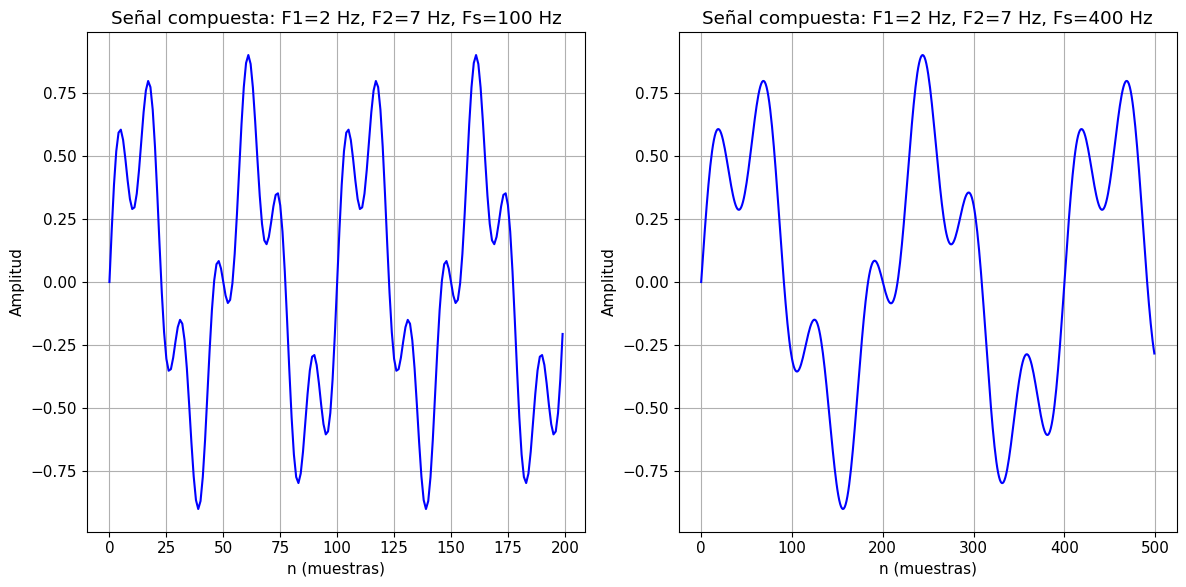

In [4]:
# === VALIDACIÓN ===
assert x_100 is not None, "Genera la señal x_100"
assert x_400 is not None, "Genera la señal x_400"
assert len(x_100) == N_100 and len(x_400) == N_400, f"Las señales debe tener {N_100} y {N_400} muestras"
assert np.max(np.abs(x_100)) <= 0.9001, f"La amplitud máxima debe ser ≤ 0.9, es {np.max(np.abs(x_100)):.3f}"
assert np.max(np.abs(x_400)) <= 0.9001, f"La amplitud máxima debe ser ≤ 0.9, es {np.max(np.abs(x_400)):.3f}"
assert np.max(np.abs(x_100)) > 0.89, "La señal debe estar escalada para max ≈ 0.9"
assert np.max(np.abs(x_400)) > 0.89, "La señal debe estar escalada para max ≈ 0.9"

print(f"✓ Señal de {T} segundos generada con F_s={F_s100}: {N_100} muestras, rango [{np.min(x_100):.3f}, {np.max(x_100):.3f}]")
print(f"✓ Señal de {T} segundos generada con F_s={F_s400}: {N_400} muestras, rango [{np.min(x_400):.3f}, {np.max(x_400):.3f}]") 

# Representa

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(n_100[:500], x_100[:500], 'b-')
plt.xlabel('n (muestras)')
plt.ylabel('Amplitud')
plt.title(f'Señal compuesta: F1={F1} Hz, F2={F2} Hz, Fs={F_s100} Hz')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(n_400[:500], x_400[:500], 'b-')
plt.xlabel('n (muestras)')
plt.ylabel('Amplitud')
plt.title(f'Señal compuesta: F1={F1} Hz, F2={F2} Hz, Fs={F_s400} Hz')
plt.grid(True)

plt.tight_layout()
plt.show()

### ✍️ Explicación (OBLIGATORIA)

**1. ¿Por qué una señal compuesta (con correlación temporal) es útil para comparar métodos PCM?**

*Tu respuesta:*

```
Porque los métodos PCM que explotan la correlación temporal (como DPCM y DM) pueden mostrar claramente sus ventajas en señales donde las muestras consecutivas son similares. Si la señal no tiene correlación temporal (como el ruido blanco), estos métodos no tendrían ninguna ventaja sobre LPCM, ya que el error de predicción sería tan grande como la señal original. Por lo tanto, una señal compuesta con correlación temporal permite evaluar cómo cada método maneja la redundancia en la señal y su impacto en la calidad de la codificación.
```

**2. ¿Qué significa "correlación temporal" intuitivamente? ¿Las muestras consecutivas de esta señal se parecen?**

*Tu respuesta:*

```
Correlación temporal se refiere a la relación entre las muestras consecutivas de una señal. Si las muestras son similares entre sí, decimos que la señal tiene alta correlación temporal. En el caso de la señal compuesta por la suma de dos sinusoides, las muestras consecutivas se parecen mucho porque las sinusoides son señales periódicas. Esto significa que cada muestra está relacionada con las anteriores y posteriores, lo que permite a los métodos PCM que explotan esta correlación.
```

### 🔍 Checkpoint del profesor (Parada 1)

- [ ] Señal compuesta generada, escalada a $\pm 0.9$
- [ ] Assert pasando sin errores

---

## Parte 2: LPCM (Linear PCM) — Cuantificación directa

### Contexto teórico

LPCM cuantifica **cada muestra independientemente** usando $B$ bits:
- No tiene en cuenta el valor de muestras anteriores ni posteriores
- Régimen binario: $R_b = B \cdot F_s$ bits/segundo
- Es el método más simple pero **no explota la correlación temporal**

**Ejemplo real:** El audio en formato WAV sin comprimir usa LPCM (16 bits, 44100 Hz → $R_b = 705{,}600$ bits/s por canal).

### Bloque 2 · Implementación de LPCM

---

#### 📝 Hipótesis previa

**Pregunta:** Con $B = 4$ bits 
- ¿Régimen binario para cada señal?: $R_b = B \times F_s$, luego $R_b = 4 \times 100 = 400$ bits/s para $F_s=100$ Hz y $R_b = 4 \times 400 = 1600$ bits/s para $F_s=400$ Hz

---

**Tareas:**
1. Cuantifica las señales, con las dos frecuencias de muestreo anteriores, con el cuantificador uniforme (ya implementado en el setup).
2. Calcula los regímenes binarios R_b_100 y R_b_200, para cada señal respectivamente.
3. Calcula MSE_100 y MSE_400, para cada señal respectivamente.
4. Calcula SQNR_100 y SQNR_400, para cada señal respectivamente.
4. Representa las señales originales vs la cuantificadas (zoom de 200 muestras).

In [5]:
# === IMPLEMENTACIÓN ===
B_lpcm_100 = B_lpcm_400 = 4  # bits

# TODO: Calcula el régimen binario, Rb_lpcm_100 y Rb_lpcm_400, para el cuantificador uniforme con B=4 bits
Rb_lpcm_100 = B_lpcm_100 * F_s100
Rb_lpcm_400 = B_lpcm_400 * F_s400

# TODO: Cuantifica la señal x_100 usando cuantificador_uniforme y su error de cuantización, x_lpcm_100, Delta_lpcm_100, e_lpcm_100
# Cuantifica x_400 usando cuantificador_uniforme y su error de cuantización, x_lpcm_400, Delta_lpcm_400, e_lpcm_400
xmin = -0.9
xmax = 0.9
x_lpcm_100, Delta_lpcm_100 = cuantificador_uniforme(x_100, B_lpcm_100, xmin, xmax)
e_lpcm_100 = x_100 - x_lpcm_100
x_lpcm_400, Delta_lpcm_400 = cuantificador_uniforme(x_400, B_lpcm_400, xmin, xmax)
e_lpcm_400 = x_400 - x_lpcm_400



# TODO: Calcula el MSE y la SQNR para x_100 y x_400, usando la función calcular_metricas
# MSE_lpcm_100, SQNR_lpcm_100, MSE_lpcm_400, SQNR_lpcm_400, según se trate de las señales x_100 o x_400
MSE_lpcm_100, SQNR_lpcm_100 = calcular_metricas(x_100, x_lpcm_100)
MSE_lpcm_400, SQNR_lpcm_400 = calcular_metricas(x_400, x_lpcm_400)



In [6]:
# === VALIDACIÓN ===
assert x_lpcm_100 is not None, "Cuantifica la señal x_100"
assert x_lpcm_400 is not None, "Cuantifica la señal x_400"
assert Rb_lpcm_100 == B_lpcm_100 * F_s100, f"Régimen binario incorrecto: {Rb_lpcm_100} bits/s, debe ser {B_lpcm_100 * F_s100} bits/s"
assert Rb_lpcm_400 == B_lpcm_400 * F_s400, f"Régimen binario incorrecto: {Rb_lpcm_400} bits/s, debe ser {B_lpcm_400 * F_s400} bits/s"
assert MSE_lpcm_100 is not None and MSE_lpcm_100 > 0, "Calcula el MSE de x_100"
assert SQNR_lpcm_100 is not None and SQNR_lpcm_100 > 0, "Calcula la SQNR de x_100"
assert MSE_lpcm_400 is not None and MSE_lpcm_400 > 0, "Calcula el MSE de x_400"
assert SQNR_lpcm_400 is not None and SQNR_lpcm_400 > 0, "Calcula la SQNR de x_400"

print(f"=== LPCM (B={B_lpcm_100} bits) para x_100 ===")
print(f"Δ = {Delta_lpcm_100:.4f}")
print(f"MSE: {MSE_lpcm_100:.6f}")
print(f"SQNR: {SQNR_lpcm_100:.2f} dB")
print(f"Régimen binario: {Rb_lpcm_100} bits/s")
print("")
print(f"=== LPCM (B={B_lpcm_400} bits) para x_400 ===")
print(f"Δ = {Delta_lpcm_400:.4f}")
print(f"MSE: {MSE_lpcm_400:.6f}")
print(f"SQNR: {SQNR_lpcm_400:.2f} dB")
print(f"Régimen binario: {Rb_lpcm_400} bits/s")

=== LPCM (B=4 bits) para x_100 ===
Δ = 0.1125
MSE: 0.001281
SQNR: 22.57 dB
Régimen binario: 400 bits/s

=== LPCM (B=4 bits) para x_400 ===
Δ = 0.1125
MSE: 0.001088
SQNR: 23.28 dB
Régimen binario: 1600 bits/s


### ✍️ Explicación (OBLIGATORIA)

**1. ¿Ves alguna diferencia importante al cuantificar las señales x_100 y x_400 con LPCM? Da una explicación.**

*Tu respuesta:*

```
La delta sigue siendo la misma, pero al tener una frecuencia de muestreo más alta (400 Hz), la señal x_400 tiene más muestras por segundo que x_100. Esto significa que aunque ambas señales se cuantifiquen con el mismo número de bits por muestra (B=4), el régimen binario para x_400 será mayor que para x_100, lo que puede resultar en una mejor calidad de la señal cuantificada debido a la mayor cantidad de información capturada por segundo.
```

---

## Parte 3: DPCM (Differential PCM) — Cuantificación del error de predicción

### Contexto teórico

DPCM explota la **correlación temporal** de la señal:

1. **Predice** la muestra actual a partir de las anteriores: $\hat{x}[n] = x_q[n-1]$ (predictor orden 1)
2. **Calcula** la diferencia: $d[n] = x[n] - \hat{x}[n]$
3. **Cuantifica** la diferencia (que tiene rango dinámico menor que la señal): $d_q[n] = Q[d[n]]$
4. **Reconstruye** en el decodificador: $x_q[n] = \hat{x}[n] + d_q[n]$

NOTA: en ocasiones, la diferencia, $d(n)$, se interpreta como un error de predicción, ya que, en el fondo, se trata del error que comete la predicción $\hat{x}[n]$ respecto a la señal original $x(n)$ . No confundamos esta denominación de la señal diferencia con el error de cuantificación, que es la señal $e(n)$ que ya conocemos.

**¿Por qué funciona?** Si la señal varía lentamente (alta correlación), el error de predicción $d[n]$ es pequeño. Cuantificar un valor pequeño con los mismos $B$ bits da **menor error de cuantificación** → mejor SQNR.

En el decodificador se usa $x_q[n-1]$ (la muestra cuantificada o reconstruida), NO $x[n-1]$ (la original). Esto evita que el error se acumule sin control (el codificador y decodificador "ven" lo mismo).

| Variable | Codificador | Decodificador |
|----------|-------------|---------------|
| Predicción | $\hat{x}[n] = x_q[n-1]$ | $\hat{x}[n] = x_q[n-1]$ |
| Diferencia | $d[n] = x[n] - \hat{x}[n]$ | (recibe $d_q[n]$) |
| Reconstrucción | $x_q[n] = \hat{x}[n] + d_q[n]$ | $x_q[n] = \hat{x}[n] + d_q[n]$ |

### Bloque 3 · Implementación de DPCM

---

#### 📝 Hipótesis previa

**Pregunta:** Si la señal cambia de forma "suave" (muestras consecutivas parecidas):
- La diferencia $d[n] = x[n] - x[n-1]$ será ¿grande o pequeño? sera pequeña ya que las muestras consecutivas son muy similares entre sí, lo que hace que la predicción sea bastante precisa.
- ¿Necesitarás más o menos rango para cuantificar $d[n]$ comparado con $x[n]$? Menos rango, porque la diferencia entre muestras consecutivas es menor que el rango total de la señal original, lo que permite usar un cuantificador con un rango dinámico más pequeño para $d[n]$.
- A igualdad de bits, ¿DPCM debería dar mejor o peor SQNR que LPCM? Mejor SQNR, porque al cuantificar la diferencia (que tiene un rango dinámico menor), el error de cuantificación será menor, lo que mejora la calidad de la señal reconstruida en comparación con cuantificar directamente cada muestra como en LPCM.

---

**Tareas:**
1. Implementa el bucle de DPCM (predictor de orden 1).
2. Elige un rango adecuado para cuantificar de la señal diferencia.
3. Calcula métricas y compara con LPCM.

**Pistas:**
- En la primera muestra ($n = 0$), vamos a suponer que la predicción es $\hat{x}[0] = 0$.
- El rango del cuantificador de la diferencia se puede estimar como: `d_range = max(|diff(x)|) * 1.5`
- Usa el `cuantificador_uniforme` del setup con `xmin=-d_range, xmax=d_range`.

In [7]:
# === Parámetros ===
B_dpcm_100 = B_dpcm_400 = 2

In [8]:
# === IMPLEMENTACIÓN ===
def dpcm_encode_decode(x, B):
    """
    DPCM con predictor de orden 1: x_hat[n] = x_rec[n-1]
    
    Parámetros:
        x: señal original
        B: bits para cuantificar el error
    
    Retorna:
        x_q: señal reconstruida
        d_range: rango usado
    """

    N = len(x)
    x_q = np.zeros(N)

    
    # TODO: Estimar rango de la señal diferencia y considera que el rango estará dentro de [-d_range, d_range)
    # donde d_range = max(|x[n] - x[n-1]|) * 1.5
    d_diff = np.abs(x[1:] - x[:-1])
    d_range = np.max(d_diff) * 1.5


    
    for i in range(N):
        # TODO: Implementa el bucle DPCM
        # 1. Predicción: x_hat = x_q[i-1] (o 0 si i==0)
        # 2. Error de predicción: d = x[i] - x_hat
        # 3. Cuantifica uniformemente con rendondeo, haciendo uso de la función de cuantificación anterior
        # 4. Reconstruye: x_q[i] = x_hat + d_q
        x_hat = x_q[i-1] if i > 0 else 0
        d = x[i] - x_hat
        d_q, _ = cuantificador_uniforme(d, B, -d_range, d_range)
        x_q[i] = x_hat + d_q
        
     
    return x_q, d_range


In [9]:
# TODO: Calcula el régimen binario, Rb_dpcm_100 y Rb_dpcm_400, para el cuantificador uniforme con B=2 bits
Rb_dpcm_100 = B_dpcm_100 * F_s100
Rb_dpcm_400 = B_dpcm_400 * F_s400   



# TODO: Ejecuta DPCM sobre las señales x_100 y x_400, obteniendo x_dpcm_100, d_range_used_100, x_dpcm_400, d_range_used_400
x_dpcm_100, d_range_used_100 = dpcm_encode_decode(x_100, B_dpcm_100)
x_dpcm_400, d_range_used_400 = dpcm_encode_decode(x_400, B_dpcm_400)


# TODO: Calcula el MSE y la SQNR para x_100 y x_400, usando la función calcular_metricas   
MSE_dpcm_100, SQNR_dpcm_100 = calcular_metricas(x_100, x_dpcm_100)
MSE_dpcm_400, SQNR_dpcm_400 = calcular_metricas(x_400, x_dpcm_400)


In [10]:
# === VALIDACIÓN ===
assert len(x_dpcm_100) == len(x_100), "La señal DPCM debe tener la misma longitud"
assert len(x_dpcm_400) == len(x_400), "La señal DPCM debe tener la misma longitud"
assert np.all(np.isfinite(x_dpcm_100)), "La señal DPCM no debe contener NaN o Inf"
assert np.all(np.isfinite(x_dpcm_400)), "La señal DPCM no debe contener NaN o Inf"
assert MSE_dpcm_100 > 0, "El MSE debe ser positivo"
assert MSE_dpcm_400 > 0, "El MSE debe ser positivo"

print(f"=== DPCM (B={B_dpcm_100} bits) para x_100 ===")
print(f"MSE: {MSE_dpcm_100:.6f}")
print(f"SQNR: {SQNR_dpcm_100:.2f} dB")
print(f"Régimen binario: {Rb_dpcm_100} bits/s")
print("")
print(f"=== DPCM (B={B_dpcm_400} bits) para x_400 ===")
print(f"MSE: {MSE_dpcm_400:.6f}")
print(f"SQNR: {SQNR_dpcm_400:.2f} dB")
print(f"Régimen binario: {Rb_dpcm_400} bits/s")


=== DPCM (B=2 bits) para x_100 ===
MSE: 0.002068
SQNR: 20.49 dB
Régimen binario: 200 bits/s

=== DPCM (B=2 bits) para x_400 ===
MSE: 0.000136
SQNR: 32.33 dB
Régimen binario: 800 bits/s


### ✍️ Explicación (OBLIGATORIA)

**1. ¿Ves alguna diferencia al cuantificar las señales x_100 y x_400 con DPCM? Da una explicación.**

*Tu respuesta:*

```
Que para la señal x_400, la frecuencia de muetreo es más alta, por lo que el regime binario es mayor, lo que permite capturar más información por segundo.
```

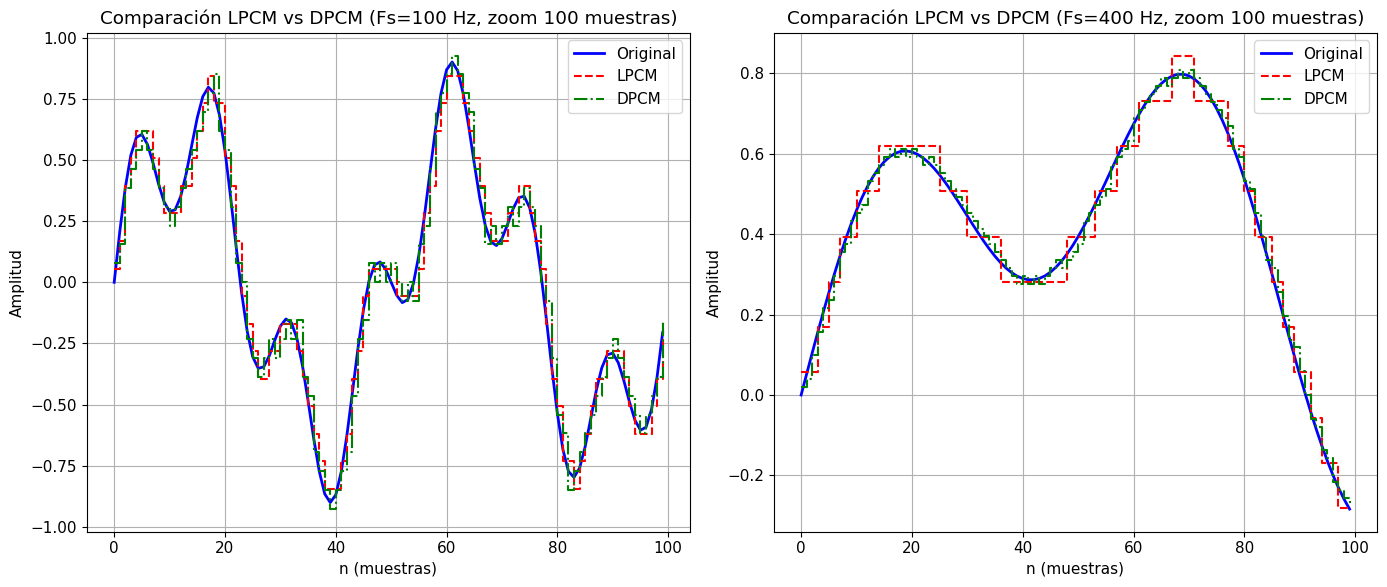

In [11]:
# Visualización comparativa (primeras 100 muestras) superponiendo en la misma gráfica la señal original x (con plot normal) y
# x_lpcm y x_dpcm (plot con drawstyle="steps-post"))
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(n_100[:100], x_100[:100], 'b-', label='Original', linewidth=2)
plt.plot(n_100[:100], x_lpcm_100[:100], 'r--', label='LPCM', drawstyle="steps-post", linewidth=1.5)
plt.plot(n_100[:100], x_dpcm_100[:100], 'g-.', label='DPCM', drawstyle="steps-post", linewidth=1.5)
plt.title(f'Comparación LPCM vs DPCM (Fs={F_s100} Hz, zoom 100 muestras)')
plt.xlabel('n (muestras)')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(n_400[:100], x_400[:100], 'b-', label='Original', linewidth=2)
plt.plot(n_400[:100], x_lpcm_400[:100], 'r--', label='LPCM', drawstyle="steps-post", linewidth=1.5)
plt.plot(n_400[:100], x_dpcm_400[:100], 'g-.', label='DPCM', drawstyle="steps-post", linewidth=1.5)
plt.title(f'Comparación LPCM vs DPCM (Fs={F_s400} Hz, zoom 100 muestras)')
plt.xlabel('n (muestras)')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### ✍️ Explicación (OBLIGATORIA)

**1. ¿DPCM es mejor a LPCM? Razona la respuesta.**

*Tu respuesta:*

```
No ya que LPCM cuantifica cada muestra directamente, mientras que DPCM cuantifica la diferencia entre muestras consecutivas. Si la señal cuenta con una alta correlacion DPCM puede llegar a ser más eficiente, pero si la señal no tiene correlación temporal, DPCM no tendrá ninguna ventaja sobre LPCM e incluso podría empeorar la calidad debido a la acumulación de errores de predicción.
```

**2. ¿Qué rango elegiste para cuantificar la señal diferencia y por qué es menor que el rango de la señal?**

*Tu respuesta:*

```
Elegí un rango para cuantificar la señal diferencia basado en el máximo valor absoluto de las diferencias entre muestras consecutivas, multiplicado por un factor de seguridad (por ejemplo, 1.5). Este rango es menor que el rango de la señal original porque la diferencia entre muestras consecutivas suele ser mucho más pequeña que el rango total de la señal, especialmente si la señal tiene alta correlación temporal. Esto permite usar un cuantificador con un rango dinámico más pequeño, lo que puede mejorar la precisión de la cuantificación y reducir el error de cuantificación.
```

**3. ¿Beneficia tener una frecuencia de muestreo más alta (400 Hz) en DPCM? Razona la respuesta.**


*Tu respuesta:*

```
Claro que sí, una frecuencia de muestreo más alta (400 Hz) en DPCM puede beneficiar la calidad de la señal reconstruida, ya que permite capturar más detalles de la señal original. Con una mayor frecuencia de muestreo, las muestras consecutivas estarán más cercanas entre sí, lo que puede aumentar la correlación temporal y hacer que el error de predicción sea aún más pequeño. Esto puede resultar en un mejor SQNR en comparación con una frecuencia de muestreo más baja (100 Hz), donde las muestras pueden ser menos similares entre sí, lo que podría aumentar el error de predicción y reducir la calidad de la señal reconstruida.
```


**4. ¿Cuándo DPCM podría empeorar respecto a LPCM? (Pista: piensa en señales sin correlación temporal)**

*Tu respuesta:*

```
Cuando las señales no tienen correlación temporal, como el ruido blanco, DPCM podría empeorar respecto a LPCM. En este caso, la diferencia entre muestras consecutivas no sería pequeña, lo que haría que el error de predicción sea grande. Cuantificar esta diferencia con los mismos bits podría resultar en un error de cuantificación mayor que el de cuantificar directamente cada muestra con LPCM, lo que reduciría la calidad de la señal reconstruida.
```

### 🔍 Checkpoint del profesor (Parada 2)

- [ ] LPCM y DPCM implementados con diferente número de bits
- [ ] Métricas calculadas: MSE, SQNR, Rb
- [ ] DPCM muestra ventaja sobre LPCM
- [ ] Explicación de por qué DPCM es mejor para señales correlacionadas

---

## Parte 4: Delta Modulation (DM) — DPCM de 1 bit

### Contexto teórico

Delta Modulation es un caso extremo de DPCM:
- **Solo 1 bit** por muestra: 1 = subir, 0 = bajar
- Paso fijo $\Delta$ (cuánto sube o baja en cada muestra)
- Régimen binario: $R_b = 1 \times F_s = F_s$ bits/segundo (**mucho menor**)
- Predictor acumulativo: $x_q[n] = x_q[n-1] \pm \Delta$

**Problemas típicos:**

| Problema | Causa | Efecto visual |
|----------|-------|---------------|
| **Granular noise** | $\Delta$ muy grande | Oscilación en zonas planas |
| **Slope overload** | $\Delta$ muy pequeño | No puede seguir cambios rápidos |

### Bloque 4 · Implementación de Delta Modulation

---

#### 📝 Hipótesis previa

**Pregunta:** DM usa solo 1 bit por muestra (subir o bajar $\Delta$). Piensa en:
- Si $\Delta$ es muy grande, ¿qué le pasa a la señal reconstruida en zonas donde la señal es constante? Lo que ocurre es que la señal reconstruida oscilará alrededor del valor constante, creando un ruido granular, ya que el paso de $\Delta$ es demasiado grande para seguir la señal plana, lo que hace que la señal reconstruida suba y baje constantemente.
- Si $\Delta$ es muy pequeño, ¿qué le pasa cuando la señal sube rápidamente? La señal reconstruida no podrá seguir los cambios rápidos de la señal original, lo que resultará en un fenómeno llamado "slope overload", donde la señal reconstruida se queda rezagada detrás de la señal original, especialmente durante transiciones rápidas, lo que puede causar una distorsión significativa.
- ¿Existirá un valor "perfecto" de $\Delta$? Si existirá un valor "perfecto" de $\Delta$ que equilibre la necesidad de seguir los cambios rápidos sin introducir demasiado ruido granular en las zonas planas. Este valor ideal dependerá de la amplitud y la frecuencia de la señal original, así como de la frecuencia de muestreo utilizada.

---

**Tareas:**
1. Implementa el bucle de DM.
2. Estima un buen valor de $\Delta$ basándote en la pendiente máxima de la señal.
3. Calcula métricas y régimen binario.

In [12]:
# === IMPLEMENTACIÓN ===
def delta_modulation(x, delta):
    """
    Delta Modulation con paso fijo.
    
    Parámetros:
        x: señal original
        delta: paso de cuantificación (cuánto sube o baja)
    
    Retorna:
        x_q: señal reconstruida
        bits: secuencia de bits (1 = subir, 0 = bajar)
    """
    N = len(x)
    x_q = np.zeros(N)
    bits = np.zeros(N, dtype=int)
    
    for i in range(N):
        # TODO: Implementa DM
        # 1. x_prev = x_q[i-1] (o 0 si i==0)
        # 2. Si x[i] >= x_prev: bit=1, x_rec[i] = x_prev + delta
        # 3. Si x[i] < x_prev:  bit=0, x_rec[i] = x_prev - delta
        x_prev = x_q[i-1] if i > 0 else 0
        if x[i] >= x_prev:
            bits[i] = 1
            x_q[i] = x_prev + delta
        else:
            bits[i] = 0
            x_q[i] = x_prev - delta
            

    
    return x_q, bits

In [13]:
delta_dm_100 = delta_dm_400 = 0.04

# TODO: Calcula el régimen binario, Rb_dm_100 y Rb_dm_400 (DM usa 1 bit por muestra)
Rb_dm_100 = F_s100  # 1 bit por muestra
Rb_dm_400 = F_s400  # 1 bit por muestra

# TODO: Cuantifica con DM y calcula MSE y SQNR para x_100 y x_400, obteniendo x_dm_100, bits_dm_100, MSE_dm_100, SQNR_dm_100, x_dm_400, bits_dm_400, MSE_dm_400, SQNR_dm_400
x_dm_100, bits_dm_100 = delta_modulation(x_100, delta_dm_100)
MSE_dm_100, SQNR_dm_100 = calcular_metricas(x_100, x_dm_100)
x_dm_400, bits_dm_400 = delta_modulation(x_400, delta_dm_400)
MSE_dm_400, SQNR_dm_400 = calcular_metricas(x_400, x_dm_400)



In [14]:
# === VALIDACIÓN ===
assert len(x_dm_100) == len(x_100), "La señal DM debe tener la misma longitud"
assert len(x_dm_400) == len(x_400), "La señal DM debe tener la misma longitud"
assert np.all(np.isfinite(x_dm_100)), "La señal DM no debe contener NaN o Inf"
assert np.all(np.isfinite(x_dm_400)), "La señal DM no debe contener NaN o Inf"
assert Rb_dm_100 == F_s100, "El régimen binario de DM debe ser Fs"
assert Rb_dm_400 == F_s400, "El régimen binario de DM debe ser Fs"

print(f"\n=== Delta Modulation para x_100 ===")
print(f"Régimen binario: {Rb_dm_100} bits/s")
print(f"Delta elegido: {delta_dm_100:.4f}")
print(f"MSE DM: {MSE_dm_100:.6f}")
print(f"SQNR DM: {SQNR_dm_100:.2f} dB")
print("")
print(f"=== Delta Modulation para x_400 ===")
print(f"Régimen binario: {Rb_dm_400} bits/s")
print(f"Delta elegido: {delta_dm_400:.4f}")
print(f"MSE DM: {MSE_dm_400:.6f}")
print(f"SQNR DM: {SQNR_dm_400:.2f} dB")


=== Delta Modulation para x_100 ===
Régimen binario: 100 bits/s
Delta elegido: 0.0400
MSE DM: 0.146370
SQNR DM: 1.99 dB

=== Delta Modulation para x_400 ===
Régimen binario: 400 bits/s
Delta elegido: 0.0400
MSE DM: 0.000971
SQNR DM: 23.77 dB


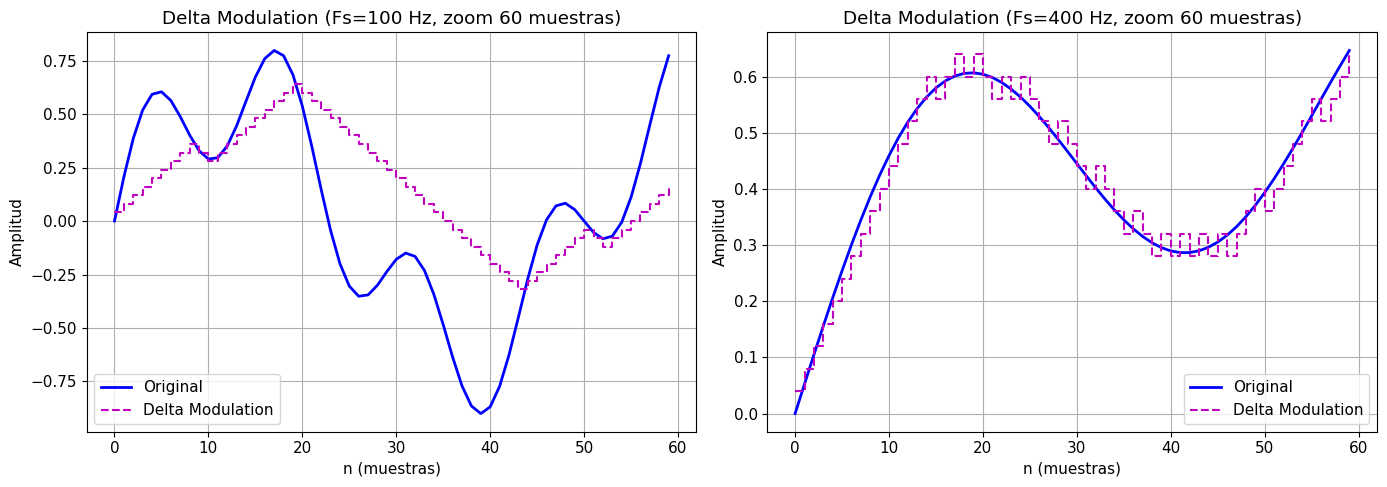

In [15]:
# Visualización (zoom de 60 muestras)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(n_100[:60], x_100[:60], 'b-', label='Original', linewidth=2)
plt.plot(n_100[:60], x_dm_100[:60], 'm--', label='Delta Modulation', drawstyle="steps-post", linewidth=1.5)
plt.title(f'Delta Modulation (Fs={F_s100} Hz, zoom 60 muestras)')
plt.xlabel('n (muestras)')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(n_400[:60], x_400[:60], 'b-', label='Original', linewidth=2)
plt.plot(n_400[:60], x_dm_400[:60], 'm--', label='Delta Modulation', drawstyle="steps-post", linewidth=1.5)
plt.title(f'Delta Modulation (Fs={F_s400} Hz, zoom 60 muestras)')
plt.xlabel('n (muestras)')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### ✍️ Explicación (OBLIGATORIA)

**1. ¿Qué observas en la cuantificación de la primera señal? ¿Cómo lo solucionarías? (Pista: haz la prueba)**

*Tu respuesta:*

```
Observo que la señal reconstruida presenta un ruido granular en las zonas planas, lo que indica que el valor de $\Delta$ es demasiado grande. Para solucionar esto, reduciría el valor de $\Delta$ para que la señal reconstruida pueda seguir más de cerca las variaciones de la señal original, especialmente en las zonas donde la señal es constante. Esto ayudaría a minimizar el ruido granular y mejorar la calidad de la señal reconstruida.
```

**2 ¿Qué es mejor una Delta grande o una Delta pequeña? Razona la respuesta.**

*Tu respuesta:*

```
Un delta pequeño es mejor para seguir cambios rápidos en la señal, pero puede introducir ruido granular en zonas planas. Un delta grande puede reducir el ruido granular, pero no podrá seguir cambios rápidos, lo que resulta en slope overload. Por lo tanto, el mejor valor de delta depende de la naturaleza de la señal: para señales con muchas variaciones rápidas, un delta pequeño es preferible, mientras que para señales más suaves, un delta más grande podría ser adecuado.
```

**3. ¿Crees que existe un $\Delta$ "perfecto" para cualquier caso en DM?**

*Tu respuesta:*

```
Creo que existe pero solo para cada señal específica, ya que el valor ideal de $\Delta$ dependerá de las características de la señal original, como su amplitud, frecuencia y la frecuencia de muestreo. 
```

**4. ¿Como afecta la frecuencia de muestreo? ¿Por qué?**

*Tu respuesta:*

```
Cuanta mas frecuencia de muestreo, mejor, ya que al tener más muestras por segundo, la señal reconstruida puede seguir más de cerca las variaciones de la señal original, lo que puede ayudar a reducir tanto el ruido granular como el slope overload. Con una frecuencia de muestreo más alta, el sistema de delta modulación tiene más oportunidades para ajustar la señal reconstruida, lo que mejora la calidad general de la señal codificada.
```

### 🔍 Checkpoint del profesor (Parada 3)

- [ ] DM implementado y funcionando
- [ ] Tres valores de Δ probados
- [ ] Granular noise y slope overload identificados visualmente
- [ ] Explicación clara del trade-off

---

## Parte 5: Comparativa final

Ahora tienes los tres métodos implementados. Vamos a comparar sus resultados en una tabla

### Bloque 5 · Tabla comparativa

---

#### 📝 Hipótesis previa

**Pregunta:** Antes de ver los números:
- ¿Cuál de los tres métodos tendrá el menor régimen binario $R_b$? DM, ya que usa solo 1 bit por muestra, lo que resulta en un régimen binario igual a la frecuencia de muestreo, que es mucho menor que los otros métodos que usan más bits por muestra.
- ¿Cuál tendrá la mejor SQNR con los mismos bits? DPCM, porque al cuantificar la diferencia entre muestras consecutivas, puede aprovechar la correlación temporal de la señal para reducir el error de cuantificación, lo que generalmente resulta en un mejor SQNR en comparación con LPCM y DM.
- ¿Cuál será más "eficiente" (mejor relación calidad/coste)? LPCM, porque aunque DPCM puede ofrecer un mejor SQNR, también requiere más complejidad en la implementación y puede ser más sensible a errores de predicción. DM, aunque tiene un régimen binario muy bajo, puede sufrir de problemas como el ruido granular y el slope overload, lo que puede afectar negativamente la calidad de la señal reconstruida. Por lo tanto, LPCM podría ser considerado más eficiente en términos de simplicidad y calidad para señales con baja correlación temporal.

---

In [22]:
# === TABLA COMPARATIVA ===
# TODO: Calcula la eficiencia para cada método (SQNR / (Rb/100)) y cada señal, x_100 y x_400
efic_lpcm_100 = SQNR_lpcm_100 / (Rb_lpcm_100 / 100)
efic_lpcm_400 = SQNR_lpcm_400 / (Rb_lpcm_400 / 100)
efic_dpcm_100 = SQNR_dpcm_100 / (Rb_dpcm_100 / 100)
efic_dpcm_400 = SQNR_dpcm_400 / (Rb_dpcm_400 / 100)
efic_dm_100 = SQNR_dm_100 / (Rb_dm_100 / 100)
efic_dm_400 = SQNR_dm_400 / (Rb_dm_400 / 100)


In [23]:
# Validaciones previas a la tabla comparativa
assert Rb_lpcm_100 == B_lpcm_100 * F_s100
assert Rb_lpcm_400 == B_lpcm_400 * F_s400
assert Rb_dpcm_100 == B_dpcm_100 * F_s100
assert Rb_dpcm_400 == B_dpcm_400 * F_s400
assert Rb_dm_100 == F_s100
assert Rb_dm_400 == F_s400

assert np.isfinite([SQNR_lpcm_100, SQNR_dpcm_100, SQNR_dm_100]).all()
assert np.isfinite([SQNR_lpcm_400, SQNR_dpcm_400, SQNR_dm_400]).all()
assert np.isfinite([efic_lpcm_100, efic_dpcm_100, efic_dm_100]).all()
assert np.isfinite([efic_lpcm_400, efic_dpcm_400, efic_dm_400]).all()

assert MSE_lpcm_100 > 0 and MSE_dpcm_100 > 0 and MSE_dm_100 > 0
assert MSE_lpcm_400 > 0 and MSE_dpcm_400 > 0 and MSE_dm_400 > 0
assert efic_lpcm_100 > 0 and efic_dpcm_100 > 0 and efic_dm_100 > 0
assert efic_lpcm_400 > 0 and efic_dpcm_400 > 0 and efic_dm_400 > 0
print("=" * 70)
print("COMPARATIVA DE MÉTODOS PCM para x_100")
print("=" * 70)
print(f"{'Método':<15} {'Bits/muestra':>12} {'Rb (bits/s)':>12} {'SQNR (dB)':>12} {'Eficiencia':>12}")
print("-" * 70)
print(f"{'LPCM':<15} {B_lpcm_100:>12} {Rb_lpcm_100:>12} {SQNR_lpcm_100:>12.2f} {efic_lpcm_100:>12.3f}")
print(f"{'DPCM':<15} {B_dpcm_100:>12} {Rb_dpcm_100:>12} {SQNR_dpcm_100:>12.2f} {efic_dpcm_100:>12.3f}")
print(f"{'DM':<15} {1:>12} {Rb_dm_100:>12} {SQNR_dm_100:>12.2f} {efic_dm_100:>12.3f}")
print("=" * 70)
print("(Eficiencia = dB de SQNR por cada 100 bits/s)")

print("\n" + "=" * 70)
print("COMPARATIVA DE MÉTODOS PCM para x_400")
print("=" * 70)
print(f"{'Método':<15} {'Bits/muestra':>12} {'Rb (bits/s)':>12} {'SQNR (dB)':>12} {'Eficiencia':>12}")
print("-" * 70)
print(f"{'LPCM':<15} {B_lpcm_400:>12} {Rb_lpcm_400:>12} {SQNR_lpcm_400:>12.2f} {efic_lpcm_400:>12.3f}")
print(f"{'DPCM':<15} {B_dpcm_400:>12} {Rb_dpcm_400:>12} {SQNR_dpcm_400:>12.2f} {efic_dpcm_400:>12.3f}")
print(f"{'DM':<15} {1:>12} {Rb_dm_400:>12} {SQNR_dm_400:>12.2f} {efic_dm_400:>12.3f}")
print("=" * 70)
print("(Eficiencia = dB de SQNR por cada 100 bits/s)")  

COMPARATIVA DE MÉTODOS PCM para x_100
Método          Bits/muestra  Rb (bits/s)    SQNR (dB)   Eficiencia
----------------------------------------------------------------------
LPCM                       4          400        22.57        5.643
DPCM                       2          200        20.49       10.246
DM                         1          100         1.99        1.994
(Eficiencia = dB de SQNR por cada 100 bits/s)

COMPARATIVA DE MÉTODOS PCM para x_400
Método          Bits/muestra  Rb (bits/s)    SQNR (dB)   Eficiencia
----------------------------------------------------------------------
LPCM                       4         1600        23.28        1.455
DPCM                       2          800        32.33        4.041
DM                         1          400        23.77        5.944
(Eficiencia = dB de SQNR por cada 100 bits/s)


### ✍️ Respuestas (OBLIGATORIA)

Basándote en tus experimentos, responde: 

> **1. Suponiendo que entre 20~23 dB de SQNR tenemos una buena calidad percibida, ¿qué esquema de codificación es más eficiente?**


*Tu respuesta:*

```
DPCM es el esquema de codificación más eficiente en términos de calidad percibida (20~23 dB de SQNR) porque explota la correlación temporal de la señal, lo que permite reducir el error de cuantificación y mejorar la calidad de la señal reconstruida en comparación con LPCM y DM. Aunque DM tiene un régimen binario muy bajo, su calidad puede verse afectada por problemas como el ruido granular y el slope overload, mientras que LPCM no aprovecha la correlación temporal, lo que puede resultar en una calidad inferior para señales con alta correlación. Por lo tanto, DPCM ofrece la mejor relación calidad/coste en este rango de SQNR.
``` 

**2. ¿Por qué ese método es más eficiente para esta señal en particular?**

*Tu respuesta:*

```
Porque la señal compuesta por la suma de dos sinusoides tiene una alta correlación temporal, lo que permite a DPCM aprovechar esta característica para reducir el error de cuantificación. Al cuantificar la diferencia entre muestras consecutivas, DPCM puede mantener un SQNR más alto con el mismo número de bits en comparación con LPCM, que cuantifica cada muestra independientemente, y DM, que solo utiliza 1 bit por muestra y puede sufrir de problemas como el ruido granular y el slope overload. Por lo tanto, DPCM es más eficiente para esta señal en particular debido a su capacidad para explotar la correlación temporal presente en la señal.
```

**3. ¿Sería el mismo resultado con una señal de ruido blanco (sin correlación temporal)? ¿Por qué?**

*Tu respuesta:*

```
No ya que en una señal de ruido blanco, que carece de correlación temporal, DPCM no tendría ninguna ventaja sobre LPCM, ya que el error de predicción sería tan grande como la señal original. En este caso, tanto DPCM como LPCM tendrían un rendimiento similar en términos de SQNR, y DM seguiría siendo menos eficiente debido a su bajo régimen binario y los problemas asociados con el ruido granular y el slope overload. Por lo tanto, el resultado sería diferente para una señal de ruido blanco, donde la falta de correlación temporal hace que DPCM no sea más eficiente que LPCM.
```

---

## Preguntas de control

Responde cada pregunta en 2–4 líneas:

### P1. ¿Por qué DPCM puede mejorar LPCM en señales con correlación temporal?

*Tu respuesta:*

```
Porque DPCM cuantifica la diferencia entre las muestras consecutivas, entonces como la señal tiene correlación temporal, estas diferencias suelen ser pequeñas, lo que permite que el error de cuantificación sea menor en comparación con LPCM, que cuantifica cada muestra independientemente sin aprovechar esta característica de la señal.
```

---

### P2. ¿Como influye el tamaño del escalón en DM? ¿Cómo compensarías el efecto de un escalón pequeño?

*Tu respuesta:*

```
Un escalón pequeño en DM puede causar slope overload, donde la señal reconstruida no puede seguir los cambios rápidos de la señal original. Para compensar este efecto, se podría aumentar el valor de $\Delta$ para permitir que la señal reconstruida siga mejor las variaciones rápidas, aunque esto podría introducir más ruido granular en zonas planas. Por lo tanto, es importante encontrar un equilibrio adecuado para el tamaño del escalón en función de las características de la señal.
```

---

### P3. Si mantienes el mismo bitrate total (bits/segundo), ¿qué trade-off aparece entre $B$ y $F_s$?

*Tu respuesta:*

```
Aparece un trade-off entre la cantidad de bits por muestra ($B$) y la frecuencia de muestreo ($F_s$). Si aumentas $B$, puedes mejorar la calidad de cada muestra, pero esto requiere reducir $F_s$ para mantener el mismo bitrate total, lo que puede resultar en una menor resolución temporal y potencialmente perder detalles rápidos de la señal. Por otro lado, si aumentas $F_s$, puedes capturar más detalles temporales, pero esto requiere reducir $B$, lo que puede aumentar el error de cuantificación y reducir la calidad de cada muestra. Por lo tanto, es necesario encontrar un equilibrio entre $B$ y $F_s$ para optimizar la calidad de la señal dentro del bitrate disponible.
```

---

---

## ✅ Checklist final

Antes de entregar, verifica:

- [ ] El notebook ejecuta completo sin errores (`Run All`)
- [ ] Las figuras están correctamente etiquetadas (título, ejes, leyenda si procede)
- [ ] Todos los `assert` pasan sin errores
- [ ] LPCM, DPCM y DM implementados y funcionando
- [ ] Tabla comparativa con métricas
- [ ] Las explicaciones están completas y son razonadas
- [ ] Las preguntas de control están respondidas

---

## 🚀 Extensiones sugeridas, opcional

Si terminas antes, intenta esto para profundizar:

### 1. DM con delta adaptada a la pendiente máxima de la señal
Para adaptar $\Delta$ mejor a la pendiente de la señal, debe ser mayor que la pendiente máxima de la señal: $\Delta > \text{pendiente máxima} = \max\left|\frac{dx}{dn}\right| \approx \max|x[n] - x[n-1]|$. Por ejemplo, podrías probar con $\Delta = 1.2 \times \max|x[n] - x[n-1]|$. ¿Mejora el seguimiento de la señal?

### 2. DM adaptativo (ADM)
Implementa un $\Delta$ que varíe: si el bit anterior fue igual al actual, duplica $\Delta$; si no, divídelo por 2. ¿Mejora el seguimiento de la señal?


---

## 📚 Resumen de conceptos clave

| Concepto | Definición corta |
|----------|------------------|
| **PCM** | Pulse Code Modulation: familia de métodos de codificación digital |
| **LPCM** | Linear PCM: cuantifica cada muestra directamente ($B$ bits/muestra) |
| **DPCM** | Differential PCM: cuantifica el error de predicción ($B$ bits/muestra) |
| **DM** | Delta Modulation: DPCM con 1 bit (solo subir/bajar) |
| **Predictor** | Estima la muestra actual a partir de las anteriores |
| **Correlación temporal** | Muestras consecutivas parecidas → error de predicción pequeño |
| **Régimen binario ($R_b$)** | $B \times F_s$ bits/segundo |
| **Granular noise** | Error en DM con $\Delta$ demasiado grande |
| **Slope overload** | Error en DM con $\Delta$ demasiado pequeño |
| **ADPCM** | DPCM con paso adaptativo (varía $\Delta$ según la señal) |

---

**Fin del Taller 4**

*Este taller demuestra que explotar la redundancia temporal de una señal permite representarla con menos bits. En el Taller 5 veremos cómo la **entropía** cuantifica el límite teórico de compresión.*